In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import parallel_backend
import shap
import pickle

# Custom modules
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [12]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'

In [13]:
dataset = SubjectDataset(data_path, selected_labels, data_string='volumes')

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [14]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

volumes = np.array([dataset[index]['volumes'] for index in range(len(dataset.subject_list))])

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

Unique labels: (array([0, 1]), array([195, 348]))



In [ ]:
scoring = 'roc_auc'

args = {
    'learning_rate':0.5,
    'max_depth': 4,
    'max_iter': 100,
    'min_samples_leaf': 150,
    'max_leaf_nodes':50,
    'l2_regularization': 7,
}

with parallel_backend('threading', n_jobs=8):

    # model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    model = HistGradientBoostingClassifier(**args, scoring=scoring, class_weight='balanced')

    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

Cross-validation roc_auc scores: [0.79 0.69 0.77 0.71 0.8  0.63 0.76 0.69 0.81 0.81]
Mean cross-validation roc_auc: 0.745155683325962
Standard deviation of cross-validation roc_auc: 0.05912523444355759


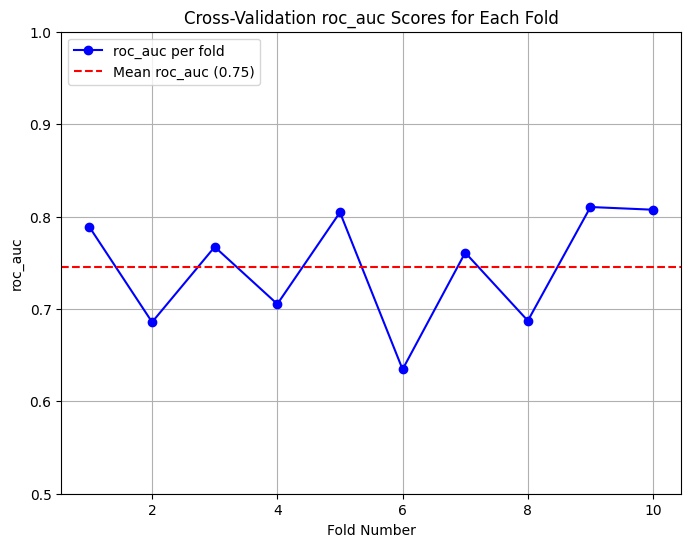

In [174]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label=f'{scoring} per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean {scoring} ({np.mean(cv_scores):.2f})')
plt.title(f'Cross-Validation {scoring} Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel(f'{scoring}')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

543


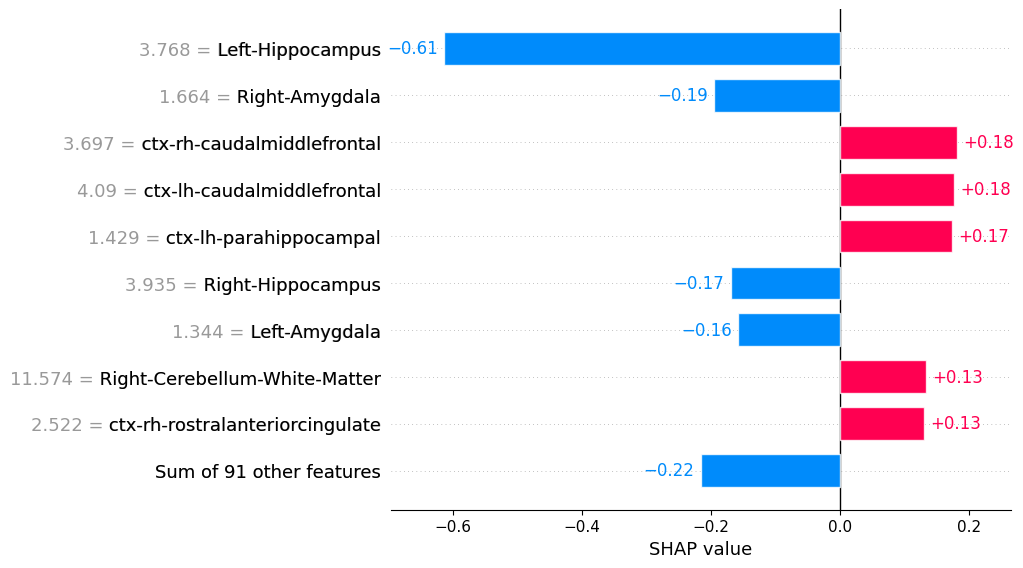

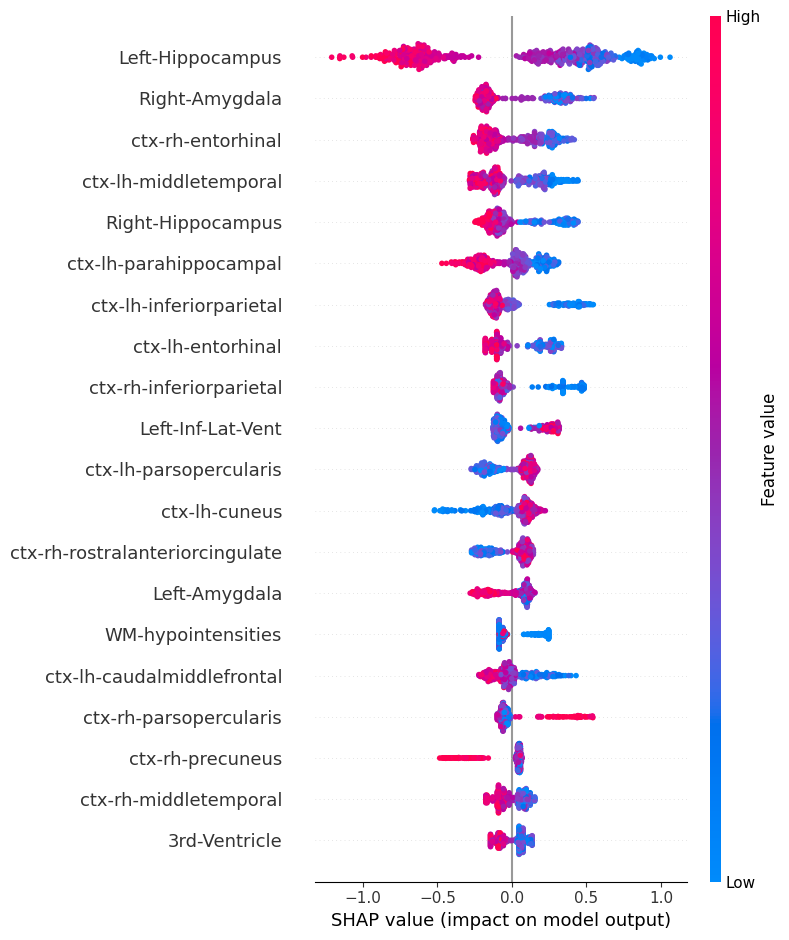

In [ ]:
model = HistGradientBoostingClassifier(**args, scoring=scoring, class_weight='balanced')

model.fit(volumes, labels)

explainer = shap.Explainer(model, feature_names=dataset[0]['struct_names'])

shap_values = explainer(volumes)

print(len(shap_values))

shap.plots.bar(shap_values[0], max_display=10)

shap.summary_plot(shap_values, volumes)


In [74]:
with open(f'volumes_gbdt.pkl', 'wb') as file:
    
    pickle.dump(model, file)  
